# Testing



In [1]:
import pandas as pd
import numpy as np
import math
from bson import ObjectId
from pymongo import MongoClient


import re
import os

import json

client = MongoClient()


In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now we load the dataset and examine how it is loaded.

In [3]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain all the dataset
res = list(books.find({}))
# Converting to pandas DataFrame
df=pd.DataFrame(res)

In [4]:
df.head()

,_id,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,6033ab6ff7ccad4a92f14abb,5,False,"03 30, 2005",A1REUF3A1YCPHM,0001713353,{'Format:': ' Hardcover'},TW Ervin II,"The King, the Mice and the Cheese by Nancy Gur...",A story children will love and learn from,1112140800,NaN,NaN
1,6033ab6ff7ccad4a92f14abc,5,True,"06 20, 2016",AVP0HXC9FG790,0001713353,NaN,Amazon Customer,The kids loved it!,Five Stars,1466380800,NaN,NaN
2,6033ab6ff7ccad4a92f14abd,5,True,"01 24, 2016",A324TTUBKTN73A,0001713353,{'Format:': ' Paperback'},Tekla Borner,My students (3 & 4 year olds) loved this book!...,Five Stars,1453593600,NaN,NaN
3,6033ab6ff7ccad4a92f14abe,5,False,"07 9, 2015",A2RE7WG349NV5D,0001713353,{'Format:': ' Paperback'},Deborah K Woroniecki,LOVE IT,Five Stars,1436400000,NaN,NaN
4,6033ab6ff7ccad4a92f14abf,5,True,"01 18, 2015",A32B7QIUDQCD0E,0001713353,NaN,E,Great!,Five Stars,1421539200,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579825 entries, 0 to 579824
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             579825 non-null  object
 1   overall         579825 non-null  int64 
 2   verified        579825 non-null  bool  
 3   reviewTime      579825 non-null  object
 4   reviewerID      579825 non-null  object
 5   asin            579825 non-null  object
 6   style           552457 non-null  object
 7   reviewerName    579803 non-null  object
 8   reviewText      579741 non-null  object
 9   summary         579756 non-null  object
 10  unixReviewTime  579825 non-null  int64 
 11  vote            109253 non-null  object
 12  image           902 non-null     object
dtypes: bool(1), int64(2), object(10)
memory usage: 53.6+ MB


In [6]:
df=df.dropna(subset=['reviewText', 'reviewerName',"summary"])

In [7]:
df["vote"].value_counts()

2      31851
3      17733
4      11282
5       7927
6       5836
       ...  
423        1
597        1
507        1
504        1
468        1
Name: vote, Length: 514, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579650 entries, 0 to 579824
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             579650 non-null  object
 1   overall         579650 non-null  int64 
 2   verified        579650 non-null  bool  
 3   reviewTime      579650 non-null  object
 4   reviewerID      579650 non-null  object
 5   asin            579650 non-null  object
 6   style           552293 non-null  object
 7   reviewerName    579650 non-null  object
 8   reviewText      579650 non-null  object
 9   summary         579650 non-null  object
 10  unixReviewTime  579650 non-null  int64 
 11  vote            109241 non-null  object
 12  image           894 non-null     object
dtypes: bool(1), int64(2), object(10)
memory usage: 58.0+ MB


In [9]:
df["vote"]=df["vote"].fillna(value=0)
df["vote"]=df["vote"].apply(lambda x: int(str(x).replace(",","")))


In [10]:
len(df[df["vote"]>1]["vote"]),len(df[df["vote"]<1]["vote"])

(109241, 470409)

In [11]:
def cleaning_review(texts):
    #Remove numbers, punctuation and lowercase everything
    res=re.sub("[^A-Za-z]+", " ", texts.lower()) 
    #Remove words with less than 4 letters
    res=re.sub(r'\b\w{1,3}\b', "", res) 
    #Remove rest of stop words
    for stopword in stopwords.words('english'): 
        sw=stopword.replace("'","")
        res=res.replace(f" {sw} "," ")
    return res

df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
dff=df.sample(frac=0.1, replace=True, random_state=1)
df=dff.reset_index()


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(min_df=5)
x = v.fit_transform(df['review_clean']).toarray()

In [15]:
df_tfidf = pd.DataFrame(x, columns=v.get_feature_names())

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_tfidf, dff["overall"], test_size=0.2, random_state=42)

In [17]:
len(y_train),len(y_test)

(46372, 11593)

In [18]:
len(df_tfidf.columns)

21983

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)


/home/ordovas/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
y_pred=clf.predict(X_train)

In [22]:
import matplotlib.pyplot as plt

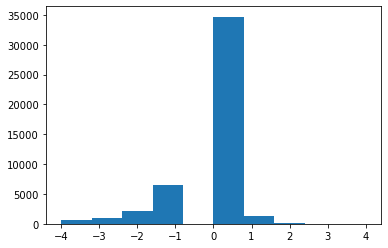

In [23]:
plt.hist(y_train-clf.predict(X_train));

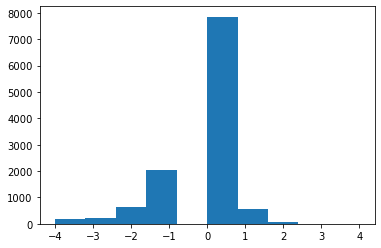

In [24]:
plt.hist(y_test-clf.predict(X_test));

In [25]:
clf.score(X_train, y_train)

0.7483395152247045

In [26]:
clf.score(X_test, y_test)

0.6775640472699043

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_train,clf.predict(X_train))

array([[  585,    97,   127,   111,   662],
       [   64,   692,   251,   248,   806],
       [   32,    57,  1566,   653,  1764],
       [   14,    18,   229,  3592,  5492],
       [   18,    13,   130,   884, 28267]])

In [29]:
confusion_matrix(y_test,clf.predict(X_test))

array([[  88,   48,   47,   28,  193],
       [  18,   56,  117,   61,  187],
       [  10,   31,  212,  255,  527],
       [   4,   11,  100,  594, 1624],
       [   4,    7,   64,  402, 6905]])